## Imports

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import random
import os
import seaborn as sns
from PIL import Image

## Pathway(s)

In [4]:
data_path = '../Data/train'

## Data Prep

In [5]:
filenames = os.listdir(data_path)
labels = []

In [6]:
for filename in filenames:
    label = filename.split('.')[0]
    if label == 'dog':
        labels.append(1) #1 for dog
    else:
        labels.append(0) #0 for gat-0

In [7]:
df = pd.DataFrame({
    'filename': filenames,
    'label': labels
})

df.sample(10)

,filename,label
8632,cat.112.jpg,0
20870,dog.384.jpg,1
2434,dog.10342.jpg,1
2331,cat.2848.jpg,0
20370,dog.5271.jpg,1
3748,dog.6614.jpg,1
1148,cat.3017.jpg,0
9668,dog.8276.jpg,1
4044,dog.10353.jpg,1
3500,dog.1594.jpg,1


In [8]:
df['label'].value_counts()

1    12500
0    12500
Name: label, dtype: int64

*Nice* This makes my life waaaay easier

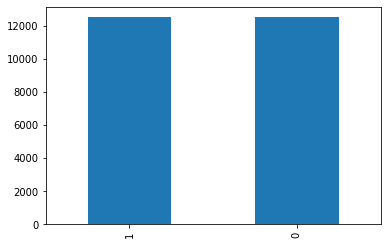

In [9]:
df['label'].value_counts().plot.bar()

I'll make something prettier wiht seaborn later

In [10]:
from PIL import Image

Time to get the average image sizes for future use

In [11]:
width = []
height = []

for filename in filenames:
    

    
    img_path = os.path.join(data_path, filename)
    im = Image.open(img_path)
    
    w, h = im.size
    
    width.append(w)
    height.append(h)
    
w_avg = sum(width)/len(width)
h_avg = sum(height)/len(height)
    
print(w_avg, h_avg)

499.0 375.0


PS: If you are looking over my code and re-running all of it the cell above will take a minute or two

Now that this is done, I'll start getting the fsm ready

## FSM

I'm going to start small and not make a super complex model for the FSM, but I am going to try out spme new things friends have told me about

### setup

In [62]:
width = int(w_avg)
height = int(h_avg)
img_size = ((width, height))
batch_size = 32

In [56]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.0001)

call_backs = [earlystop, learning_rate_reduction]

import tensorflow as tf
import tensorflow.keras.preprocessing as preprocessing
from keras.preprocessing.image import ImageDataGenerator

In [14]:
df['label'] = df['label'].replace({0:'cat', 1:'dog'})

In [15]:
X_t, v_t = train_test_split(df, test_size = 0.15,  random_state = 7)
X_t = X_t.reset_index(drop = True)
v_t = v_t.reset_index(drop=True)

In [18]:
X_t['label'].value_counts()

dog    10629
cat    10621
Name: label, dtype: int64

In [19]:
v_t['label'].value_counts()

cat    1879
dog    1871
Name: label, dtype: int64

Close enough

### generators

In [67]:
img_gen = ImageDataGenerator(rescale = 1./255., horizontal_flip = True) #keeping it simple for now

train_generator = img_gen.flow_from_dataframe(
    X_t,
    data_path,
    x_col = 'filename',
    y_col = 'label',
    target_size = (499, 375),
    batch_size = batch_size,
    class_mode ='categorical'
)

val_img_gen = ImageDataGenerator(rescale = 1./255.) #keeping it simple for now

val_generator = img_gen.flow_from_dataframe(
    v_t,
    data_path,
    x_col = 'filename',
    y_col = 'label',
    target_size = (499, 375), #img_size, maybe this will fix the problem?
    batch_size = batch_size,
    class_mode ='categorical'
)

Found 21250 validated image filenames belonging to 2 classes.
Found 3750 validated image filenames belonging to 2 classes.


### model

In [48]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from sklearn.model_selection import train_test_split

In [64]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

fsm = Sequential() 
fsm.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (width, height, 3)))#3 for rgb
fsm.add(MaxPooling2D(pool_size=(2, 2)))
fsm.add(BatchNormalization())
fsm.add(Dropout(0.20))

fsm.add(Conv2D(64, (3, 3), activation = 'relu'))
fsm.add(MaxPooling2D((2, 2)))
fsm.add(BatchNormalization())
fsm.add(Dropout(0.20))

fsm.add(Conv2D(128, (3, 3), activation = 'relu'))
fsm.add(MaxPooling2D((2, 2)))
fsm.add(BatchNormalization())
fsm.add(Dropout(0.20))

fsm.add(Flatten())
fsm.add(Dense(64, activation='relu'))
fsm.add(BatchNormalization())
fsm.add(Dropout(0.20))

fsm.add(Dense(128, activation='relu'))
fsm.add(BatchNormalization())
fsm.add(Dropout(0.20))

fsm.add(Dense(2, activation='softmax')) #2 for cat or dog (or based or cringe)
fsm.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

fsm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 497, 373, 32)      896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 248, 186, 32)      0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 248, 186, 32)      128       
_________________________________________________________________
dropout_15 (Dropout)         (None, 248, 186, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 246, 184, 64)      18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 123, 92, 64)       0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 123, 92, 64)       256       
__________

In [68]:
history_fsm = fsm.fit_generator(
    train_generator, 
    epochs = 10, #callbacks didnt wanna work, will up it should it start working
    validation_data = val_generator,
    validation_steps = 20,
    steps_per_epoch = 100,
    callbacks = call_backs #for now, didn't want to behave 
)

Epoch 1/10
100/100 [==============================] - 1183s 12s/step - loss: 0.6860 - acc: 0.6112 - val_loss: 0.6924 - val_acc: 0.6281
Epoch 2/10
100/100 [==============================] - 1195s 12s/step - loss: 0.6433 - acc: 0.6431 - val_loss: 0.8046 - val_acc: 0.5703
Epoch 3/10
100/100 [==============================] - 1172s 12s/step - loss: 0.6042 - acc: 0.6672 - val_loss: 0.6262 - val_acc: 0.6687
Epoch 4/10
100/100 [==============================] - 1178s 12s/step - loss: 0.5716 - acc: 0.6991 - val_loss: 0.6149 - val_acc: 0.6375
Epoch 5/10
100/100 [==============================] - 1211s 12s/step - loss: 0.5667 - acc: 0.7106 - val_loss: 0.5723 - val_acc: 0.6906
Epoch 6/10
100/100 [==============================] - 1184s 12s/step - loss: 0.5441 - acc: 0.7244 - val_loss: 0.5065 - val_acc: 0.7345
Epoch 7/10
100/100 [==============================] - 1174s 12s/step - loss: 0.5537 - acc: 0.7207 - val_loss: 0.5168 - val_acc: 0.7453
Epoch 8/10
100/100 [==============================] - 1

In [57]:
def vis_history(history): 
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [70]:
fsm_ = Sequential() 
fsm_.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (width, height, 3)))#3 for rgb
fsm_.add(MaxPooling2D(pool_size=(2, 2)))
fsm_.add(BatchNormalization())
fsm_.add(Dropout(0.20))

fsm_.add(Conv2D(64, (3, 3), activation = 'relu'))
fsm_.add(MaxPooling2D((2, 2)))
fsm_.add(BatchNormalization())
fsm_.add(Dropout(0.20))

fsm_.add(Conv2D(128, (3, 3), activation = 'relu'))
fsm_.add(MaxPooling2D((2, 2)))
fsm_.add(BatchNormalization())
fsm_.add(Dropout(0.20))

fsm_.add(Flatten())
fsm_.add(Dense(64, activation='relu'))
fsm_.add(BatchNormalization())
fsm_.add(Dropout(0.20))

fsm_.add(Dense(128, activation='relu'))
fsm_.add(BatchNormalization())
fsm_.add(Dropout(0.20))

fsm_.add(Dense(2, activation='softmax')) #2 for cat or dog (or based or cringe)
fsm_.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

fsm_.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 497, 373, 32)      896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 248, 186, 32)      0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 248, 186, 32)      128       
_________________________________________________________________
dropout_20 (Dropout)         (None, 248, 186, 32)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 246, 184, 64)      18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 123, 92, 64)       0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 123, 92, 64)       256       
__________

In [71]:
history_fsm_ = fsm_.fit_generator(
    train_generator, 
    epochs = 30, #callbacks now working
    validation_data = val_generator,
    validation_steps = 20,
    steps_per_epoch = 100,
    callbacks = call_backs 
)

Epoch 1/30
100/100 [==============================] - 1227s 12s/step - loss: 0.8532 - acc: 0.5619 - val_loss: 0.6970 - val_acc: 0.6172
Epoch 2/30
100/100 [==============================] - 1171s 12s/step - loss: 0.7306 - acc: 0.5903 - val_loss: 0.7035 - val_acc: 0.5831
Epoch 3/30
100/100 [==============================] - 1174s 12s/step - loss: 0.6879 - acc: 0.6175 - val_loss: 0.6860 - val_acc: 0.6844
Epoch 4/30
100/100 [==============================] - 1199s 12s/step - loss: 0.6308 - acc: 0.6516 - val_loss: 0.6535 - val_acc: 0.6172
Epoch 5/30
100/100 [==============================] - 1202s 12s/step - loss: 0.6235 - acc: 0.6550 - val_loss: 0.7941 - val_acc: 0.6328

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/30
100/100 [==============================] - 1165s 12s/step - loss: 0.5898 - acc: 0.6762 - val_loss: 0.5284 - val_acc: 0.7141
Epoch 7/30
100/100 [==============================] - 1167s 12s/step - loss: 0.5799 - acc: 0.6981 - val_loss:

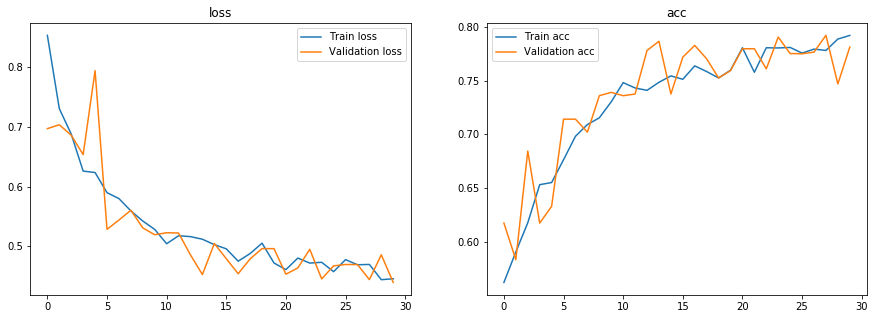

In [72]:
vis_history(history_fsm_)

That went great! Time to make it better. Looks like it could use even more epochs, I'll also play around with the layers more.